In [1]:
import pandas as pd
import dask.dataframe as dd

import imp

prepare_data = imp.load_source('prepare_data', '../src/prepare_data.py')
process_data = imp.load_source('processe_data', '../src/process_data.py')

In [2]:
import seaborn as sns
import numpy as np
import matplotlib

In [3]:
import matplotlib.pyplot as plt

In [4]:
font = {"size": 10, "weight": "bold"}
matplotlib.rc("font", **font)

In [5]:
color = matplotlib.cm.viridis(0.3)

In [6]:
color_c = matplotlib.cm.viridis(0.4)

**Top perfomances**

In [ ]:
dfs = []
for name in ['standard', 'noise', 'probend', 'probend_noise']:
    df = pd.read_csv('../data/%s_3_processed.csv' % name, index_col=0
                           )
    df['type'] = name
    dfs.append(df)

//anaconda3/envs/axlml/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


**Descriptive measures**

In [ ]:
[df.size for df in dfs]

In [ ]:
unique_number_of_seeds = len(dfs[0].seed.unique())
unique_number_of_seeds

In [10]:
file = open('../paper/unique_number_of_seeds.tex', "w")
file.write("{}".format(unique_number_of_seeds))
file.close()

In [ ]:
len(dfs[0]['Name'].unique())

In [12]:
file = open('../paper/unique_number_of_strategies.tex', "w")
file.write("{}".format(len(dfs[0]['Name'].unique())))
file.close()

In [11]:
number_of_all_tournaments = sum([len(df.seed.unique()) for df in dfs])

In [14]:
file = open('../paper/number_of_all_tournaments.tex', "w")
file.write("{}".format(number_of_all_tournaments))
file.close()

In [12]:
summary_table = dfs[0].groupby('Name').count()['seed'].describe()
summary_table

count     195.000000
mean     5154.066667
std       187.608747
min      4693.000000
25%      5041.000000
50%      5147.000000
75%      5286.500000
max      5639.000000
Name: seed, dtype: float64

In [16]:
file = open('../paper/summary_table_of_entries.tex', "w")
file.write("{}".format(pd.DataFrame(summary_table).rename(columns={"seed": "entries"}).T.round().to_latex()))
file.close()

**Top performances tables**

In [ ]:
average_prfs = []
for df in dfs:
    df_type = df['type'].unique()[0]
    average_prfs.append(df.groupby(['Name']).median()['Normalized_Rank'].round(decimals=3))
    
    if df_type == 'noise':
        temp = df[df['noise'] < 0.10]
        average_prfs.append(temp.groupby(['Name']).median()['Normalized_Rank'].round(decimals=3))
        
    if df_type == 'probend':
        temp = df[df['probend'] < 0.10]
        average_prfs.append(temp.groupby(['Name']).median()['Normalized_Rank'].round(decimals=3))

In [ ]:
columns = []
for prfs in average_prfs:
    columns.append(prfs.sort_values()[:15].index)
    columns.append(prfs.sort_values()[:15].values)

In [ ]:
table = pd.DataFrame.from_records(columns,).T

In [ ]:
table.columns = ['Name', r'$\bar{r}$'] * 6

In [ ]:
table

In [58]:
file = open('../paper/perfomances_table.tex', "w")
file.write(table.to_latex())
file.close()

In [23]:
for prf, tps in zip(average_prfs, types):
    table = pd.DataFrame(prf.sort_values()[:15])
    table = table.rename(columns={'Normalized_Rank':
                                  r'$\bar{r}$ in %s tournaments' % tps})
    table.to_latex('../paper/performance_%s_table.tex' % tps)
    

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import gaussian_kde

%matplotlib inline

In [ ]:
def get_distribution_without_outliers(distribution, percentage=0.1):
    distribution.sort()
    size_of_ditribution = len(distribution)
    outliers = int(size_of_ditribution * (percentage))
    
    return distribution[:-outliers]

**Top variation**

In [ ]:
def plot_perfomance_violin_plots(type_index,
                                 tournament_type,
                                 top_names,
                                 ylim_up=1,
                                 remove_outliers=False,
                                 percentage=0.1):
    data, violin_data = [], []
    for name in top_names:
        distribution = dfs[type_index][dfs[type_index]['Name'] == name]['Normalized_Rank'].values
        
        data.append(distribution)
        
        if remove_outliers:
            distribution = get_distribution_without_outliers(distribution, percentage)
        violin_data.append(distribution)

    means = [np.mean(dt) for dt in data]

    fig, axes = plt.subplots(figsize=(10, 4))

    parts = axes.violinplot(violin_data, showextrema=False,
                            showmeans=False);

    boxes = axes.boxplot(data, showfliers=False)
    axes.scatter(range(1, len(means) + 1), means, marker='o', color='purple', zorder=3, s=50)

    for pc in parts['bodies']:
        pc.set_facecolor('lightsteelblue')
        pc.set_edgecolor('black')
        pc.set_alpha(.60)

    for bp in boxes['medians']:
        bp.set_color('purple')
        bp.set_linewidth(2)
        bp.set_linestyle('-.')
    for bp in boxes['caps']:
        bp.set_color('navy')
        bp.set_linewidth(2)
    for bp in boxes['whiskers']:
        bp.set_color('navy')
        bp.set_linewidth(2)
    for bp in boxes['boxes']:
        bp.set_color('navy')
        bp.set_linewidth(2)

    axes.set_ylabel(r'$r$')
    axes.set_ylim([0, ylim_up]);
    axes.set_xticklabels(list(top_names), rotation=90);

    fig.savefig('../images/performance_%s.pdf' % tournament_type,
                bbox_inches='tight')

In [ ]:
tournament_types = ['standard', 'noisy', 'probabilistic ending', 'noisy probabilistic ending']

In [ ]:
color = 

//anaconda3/envs/axlml/lib/python3.6/site-packages/matplotlib/mathtext.py:2468: SyntaxWarning: Exception creating Regex for oneOf, building MatchFirst
  p.subsuperop    <<= oneOf(["_", "^"])


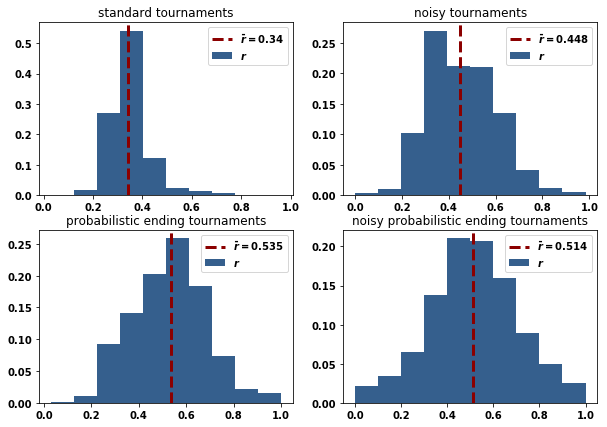

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 7))

for i in range(4):
    index = (int(i / 2), i % 2)

    values = dfs[i][dfs[i]['Name'] == 'Tit For Tat']['Normalized_Rank'].unique()
    weights = np.ones_like(values) / float(len(values))
    axes[index].hist(values, weights=weights, color=color, label=r'$r$')
    axes[index].axvline(
        np.median(values),
        color="darkred",
        linestyle="dashed",
        linewidth=3,
        label=r"$\bar{r}=%s$" % round(np.median(values), 3),
    )
    axes[index]
    axes[index].set_title(r'%s tournaments' % tournament_types[i])
    axes[index].legend();
# plt.savefig('../images/tit_for_tat_r_distributions.pdf', bbox_inches='tight')

**Standard tournaments**

In [ ]:
np.mean(dfs[0]['size']), np.mean(dfs[0]['turns']), np.mean(dfs[0]['repetitions'])

In [ ]:
len(dfs[0]['Name'].unique())

In [ ]:
len(dfs[0][dfs[0]['Name'] == 'Tit For Tat'].seed.unique())

In [ ]:
len(dfs[0][dfs[0]['Name'] == 'Tit For Tat']['Normalized_Rank'].unique())

In [ ]:
np.mean(df.groupby(['Name', 'seed']).size().reset_index().groupby("Name").count()['seed'].values)

In [ ]:
top_names = list(average_prfs[0].sort_values()[:15].index)

In [ ]:
plot_perfomance_violin_plots(type_index=0,
                             tournament_type=types[0],
                             top_names=top_names,
                             ylim_up=0.22,
                             remove_outliers=True,
                             percentage=0.15)

**Noise**

In [ ]:
np.mean(dfs[1]['size']), np.mean(dfs[1]['turns']), np.mean(dfs[1]['repetitions']), np.mean(dfs[1]['noise'])

In [ ]:
top_names_noise = list(average_prfs[1].sort_values()[:15].index)

In [ ]:
plot_perfomance_violin_plots(type_index=1,
                             tournament_type=types[1],
                             top_names=top_names_noise,
                             ylim_up=1.01)

**Probabilistic ending**

In [ ]:
np.mean(dfs[2]['probend'])

In [ ]:
top_names_probend = list(average_prfs[2].sort_values()[:15].index)

In [ ]:
plot_perfomance_violin_plots(type_index=2,
                             tournament_type=types[2],
                             top_names=top_names_probend,
                             ylim_up=.23,
                             remove_outliers=True,
                             percentage=0.17)

**Probend noisy**

In [31]:
top_names_mixed = list(average_prfs[3].sort_values()[:15].index)

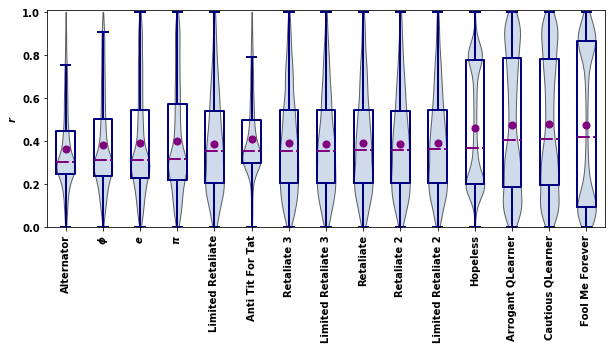

In [41]:
plot_perfomance_violin_plots(type_index=3,
                             tournament_type=types[3],
                             top_names=top_names_mixed,
                             ylim_up=1.01)

In [32]:
distributions = [dfs[-1][dfs[-1]['Name'] == name]['Normalized_Rank'].values for name in top_names_mixed]

In [33]:
import scipy.stats as stats

In [34]:
stats.f_oneway(*distributions)

F_onewayResult(statistic=124.77533668109545, pvalue=0.0)

In [35]:
s, p = stats.kruskal(*distributions)

In [36]:
p

4.365799914896071e-141

**Overall**

In [220]:
dfs_j_rank = [df[['Normalized_Rank', 'Name']] for df in dfs]

In [221]:
ranks = pd.concat(dfs_j_rank).groupby(['Name']).median()['Normalized_Rank'].round(3)

In [222]:
top_names_overall = list(ranks.sort_values()[:15].index)

In [223]:
top_names_mixed = list(average_prfs[3].sort_values()[:15].index)

In [224]:
file = open('../paper/performance_merged_table.tex', "w")
file.write(ranks.sort_values()[:15].to_latex())
file.close()

**Cooperating Ratios**

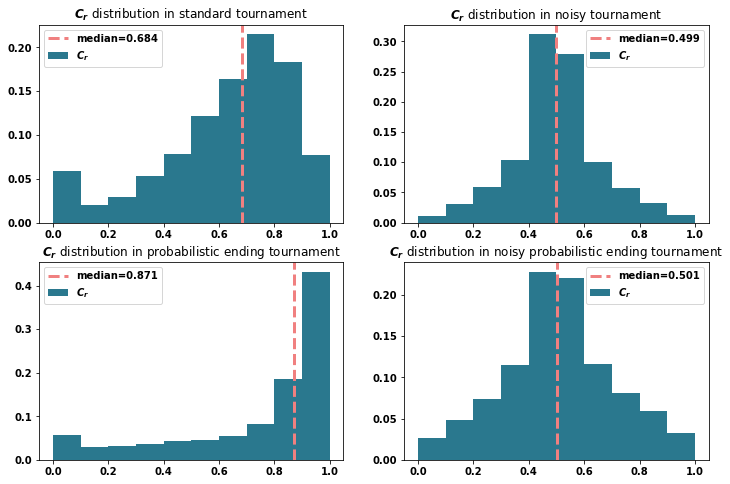

In [52]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

titles = ["standard", "noisy", "probabilistic ending", "noisy probabilistic ending"]
for i in range(4):
    index = (int(i / 2), i % 2)
    values = dfs[i]['Cooperation_rating']
    weights = np.ones_like(values) / float(len(values))
    axes[index].hist(values, weights=weights, color=color_c, label=r'$C_r$')
    axes[index].axvline(
        np.median(values),
        color="lightcoral",
        linestyle="dashed",
        linewidth=3,
        label="median=%s" % round(np.median(values), 3),
    )
    axes[index].set_title(r'$C_r$ distribution in %s tournament' % titles[i])
    axes[index].legend()
    
plt.savefig('../images/cooperation_ratings.pdf', bbox_inches='tight')

**Folk Theorem**

In [41]:
from scipy import optimize


def func(x, a, b, c):
    return a *  np.array(x) ** 2 + b * np.array(x) + c

//anaconda3/envs/axlml/lib/python3.6/site-packages/matplotlib/mathtext.py:2468: SyntaxWarning: Exception creating Regex for oneOf, building MatchFirst
  p.subsuperop    <<= oneOf(["_", "^"])


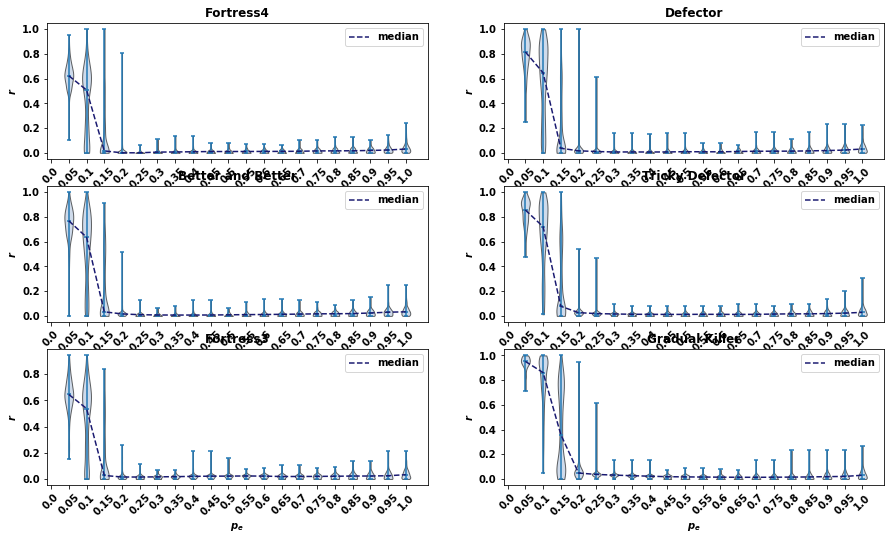

In [46]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 8.5))
probend_val = np.linspace(0, 1, 21)
probend_val = [round(val, 2) for val in probend_val]
for i, name in enumerate(top_names_probend[:6]):
    temp = dfs[2][dfs[2]['Name'] == name][['probend', 'Normalized_Rank']]
    index = (int(i / 2), i % 2)
    
    distributions = []
    for j, val in enumerate(probend_val[1:]):
        if j !=0:
            distributions.append(temp[(temp['probend'] <= val) & (temp['probend'] > probend_val[j-1])]['Normalized_Rank'])
        else:
            distributions.append(temp[(temp['probend'] <= val)]['Normalized_Rank'])
    
    violin_data = [distribution.values for distribution in distributions]
    medians = [np.nan] + [np.median(distribution) for distribution in distributions]
    axes[index].plot(medians, color='midnightblue', linestyle='--', label='median')
    parts = axes[index].violinplot(violin_data, showmedians=True);
    axes[index].set_title(name, fontweight='bold')
    axes[index].set_ylabel('$r$')
    axes[index].set_xlabel('$p_e$')
    axes[index].set_xlabel('$p_e$')

    axes[index].set_xticks(range(len(probend_val)))
    axes[index].set_xticklabels(probend_val, rotation=45)
    
    for pc in parts['bodies']:
        pc.set_facecolor('lightsteelblue')
        pc.set_edgecolor('black')
        pc.set_alpha(.60)
    axes[index].legend()
        
# fig.tight_layout()
# plt.savefig('../images/folk_theorem.pdf', bbox_inches='tight')

In [22]:
probend = dfs[2][dfs[2]['probend'] < 0.10]

In [23]:
len(probend['seed'].unique())

1139

In [24]:
probend.groupby(['Name']).median()['Normalized_Rank'].round(decimals=5).sort_values()[:15]

Name
Evolved FSM 16               0.00000
Evolved FSM 16 Noise 05      0.01266
MEM2                         0.02715
Evolved HMM 5                0.04423
EvolvedLookerUp2_2_2         0.04870
Spiteful Tit For Tat         0.05958
Nice Meta Winner             0.06842
NMWE Finite Memory           0.06923
Grudger                      0.06985
NMWE Deterministic           0.07018
NMWE Long Memory             0.07407
Nice Meta Winner Ensemble    0.07595
EvolvedLookerUp1_1_1         0.07692
NMWE Memory One              0.08000
NMWE Stochastic              0.08475
Name: Normalized_Rank, dtype: float64

In [192]:
table = pd.DataFrame(probend.groupby(['Name']).median()['Normalized_Rank'].round(decimals=5).sort_values()[:15])
table = table.rename(columns={'Normalized_Rank':
                              r'$\bar{r}$'})
table.to_latex('../paper/performance_probend_subset_table.tex')

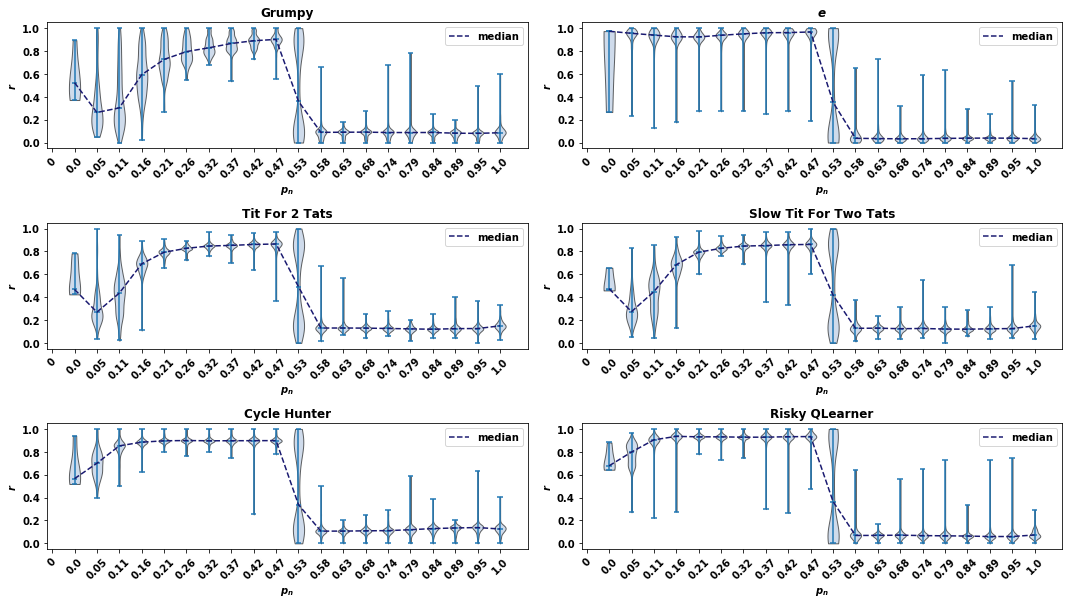

In [193]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 8.5))
noise_val = np.linspace(0, 1, 20)
noise_val = [round(val, 2) for val in noise_val]
for i, name in enumerate(top_names_noise[:6]):
    temp = dfs[1][dfs[1]['Name'] == name][['noise', 'Normalized_Rank']].round({'noise': 3})
    index = (int(i / 2), i % 2)
    
    distributions = []
    for j, val in enumerate(noise_val):
        if j !=0:
            distributions.append(temp[(temp['noise'] <= val) & (temp['noise'] > noise_val[j-1])]['Normalized_Rank'])
        else:
            distributions.append(temp[(temp['noise'] <= val)]['Normalized_Rank'])
    
    violin_data = [distribution.values for distribution in distributions]
    parts = axes[index].violinplot(violin_data, showmedians=True);
    medians = [np.nan] + [np.median(distribution) for distribution in distributions]
    axes[index].plot(medians, color='midnightblue', linestyle='--', label='median')
    axes[index].set_title(name, fontweight='bold')
    axes[index].set_ylabel('$r$')
    axes[index].set_xlabel('$p_n$')
    axes[index].set_xticks(range(21))
    axes[index].set_xticklabels([0] + noise_val, rotation=45)
    
    for pc in parts['bodies']:
        pc.set_facecolor('lightsteelblue')
        pc.set_edgecolor('black')
        pc.set_alpha(.60)
    axes[index].legend();
fig.tight_layout()

# plt.savefig('../images/noise_effect.pdf', bbox_inches='tight')

In [25]:
top_names = probend.groupby(['Name']).median()['Normalized_Rank'].round(decimals=3).sort_values()[:15].index

In [32]:
remove_outliers = True
percentage = 0.05


data, violin_data = [], []
for name in top_names:
    distribution = probend[probend['Name'] == name]['Normalized_Rank'].values

    data.append(distribution)
    if remove_outliers:
        distribution = get_distribution_without_outliers(distribution, percentage)
    violin_data.append(distribution)

means = [np.mean(dt) for dt in data]

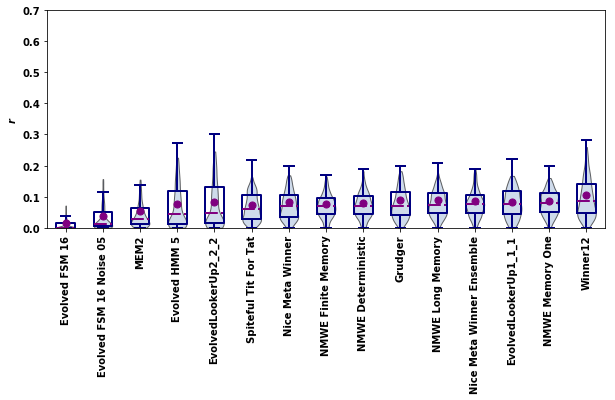

In [33]:
fig, axes = plt.subplots(figsize=(10, 4))

parts = axes.violinplot(violin_data, showextrema=False,
                        showmeans=False);

boxes = axes.boxplot(data, showfliers=False)
axes.scatter(range(1, len(means) + 1), means, marker='o', color='purple', zorder=3, s=50)

for pc in parts['bodies']:
    pc.set_facecolor('lightsteelblue')
    pc.set_edgecolor('black')
    pc.set_alpha(.60)

for bp in boxes['medians']:
    bp.set_color('purple')
    bp.set_linewidth(2)
    bp.set_linestyle('-.')
for bp in boxes['caps']:
    bp.set_color('navy')
    bp.set_linewidth(2)
for bp in boxes['whiskers']:
    bp.set_color('navy')
    bp.set_linewidth(2)
for bp in boxes['boxes']:
    bp.set_color('navy')
    bp.set_linewidth(2)

axes.set_ylabel(r'$r$')
axes.set_ylim([0, 0.7]);
axes.set_xticklabels(list(top_names), rotation=90);

plt.savefig('../images/probend_performance_subset.pdf', bbox_inches='tight')

**Noise**

In [45]:
noise = dfs[1][dfs[1]['noise'] < 0.50]

In [46]:
noise.groupby(['Name']).median()['Normalized_Rank'].round(decimals=5).sort_values()[:15]

Name
MEM2                         0.06135
Spiteful Tit For Tat         0.06344
Nice Meta Winner             0.06620
Grudger                      0.06667
Meta Winner Long Memory      0.07339
Forgiver                     0.07362
Fool Me Once                 0.07362
Meta Winner                  0.07487
Meta Winner Memory One       0.07621
Meta Winner Finite Memory    0.07692
Meta Winner Deterministic    0.07792
NMWE Deterministic           0.08696
NMWE Long Memory             0.08696
CollectiveStrategy           0.08696
Defector                     0.08889
Name: Normalized_Rank, dtype: float64

In [56]:
len(noise['seed'].unique())

5661

In [374]:
table = pd.DataFrame(noise.groupby(['Name']).median()['Normalized_Rank'].round(decimals=5).sort_values()[:15])
table = table.rename(columns={'Normalized_Rank':
                              r'$\bar{r}$'})
table.to_latex('../paper/performance_noise_subset_table.tex')

**Noise smaller than 0.5**

In [60]:
noise = dfs[1][dfs[1]['noise'] < 0.10]

In [61]:
noise.groupby(['Name']).median()['Normalized_Rank'].round(decimals=5).sort_values()[:15]

Name
DBS                           0.00000
Evolved FSM 16 Noise 05       0.00813
Evolved ANN 5 Noise 05        0.01270
BackStabber                   0.02353
DoubleCrosser                 0.02454
Evolved ANN 5                 0.02817
Evolved ANN                   0.03846
Evolved HMM 5                 0.05102
Spiteful Tit For Tat          0.05147
Level Punisher                0.05195
Omega TFT                     0.05882
Fool Me Once                  0.05882
PSO Gambler 2_2_2 Noise 05    0.06667
Evolved FSM 16                0.07843
EugineNier                    0.07989
Name: Normalized_Rank, dtype: float64

In [85]:
noise_val = np.linspace(0, 0.1, 20)
noise_val = [round(val, 2) for val in noise_val]

In [128]:
noise = dfs[1][dfs[1]['noise'] < noise_val[1]]

In [129]:
names = noise.groupby(['Name']).median()['Normalized_Rank'].round(decimals=5).sort_values()[:6].index

In [130]:
ranks = []
for val in noise_val[1:]:
    noise = dfs[1][dfs[1]['noise'] < val]
    values = []
    for name in names:
        values.append(noise[noise['Name']  == name]['Normalized_Rank'].median())
    ranks.append(values)

In [131]:
names

Index(['Evolved FSM 16 Noise 05', 'Evolved ANN 5', 'Evolved HMM 5', 'DBS',
       'Evolved ANN', 'BackStabber'],
      dtype='object', name='Name')

In [132]:
lines = ['--', '-o', '-', '-.', '--o', '-.o']

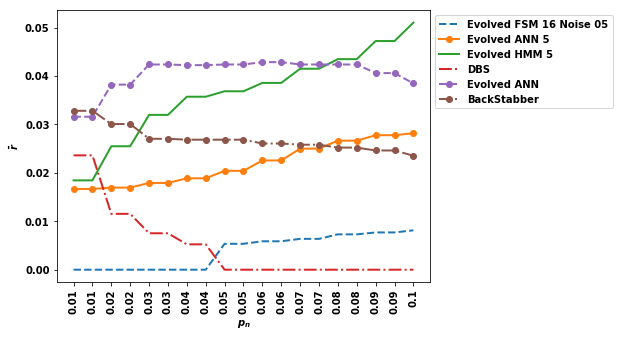

In [144]:
fig, ax = plt.subplots(figsize=(6.7, 5))
d, b, s, eva5, eva, f = zip(*ranks)

for i, plot in enumerate([d, b, s, eva5, eva, f]):
    plt.plot(plot, lines[i], label=names[i], linewidth=2)


ax.set_xticks(range(19));
ax.set_xticklabels(noise_val[1:], rotation=90);

ax.legend(bbox_to_anchor=(1.0, 1.00));

ax.set_ylabel(r'$\bar{r}$');
ax.set_xlabel(r'$p_n$');

plt.savefig('../images/top_six_restricted_noise.pdf', bbox_inches='tight')

In [150]:
noise = dfs[1][dfs[1]['noise'] < 0.1]

In [151]:
top_names = noise.groupby(['Name']).median()['Normalized_Rank'].round(decimals=5).sort_values()[:15].index

In [182]:
remove_outliers = True
percentage = 0.1

In [183]:
data, violin_data = [], []
for name in top_names:
    distribution = noise[noise['Name'] == name]['Normalized_Rank'].values

    data.append(distribution)
    if remove_outliers:
        distribution = get_distribution_without_outliers(distribution, percentage)
    violin_data.append(distribution)

In [184]:
means = [np.mean(dt) for dt in data]

In [187]:
len(noise['seed'].unique())

1151

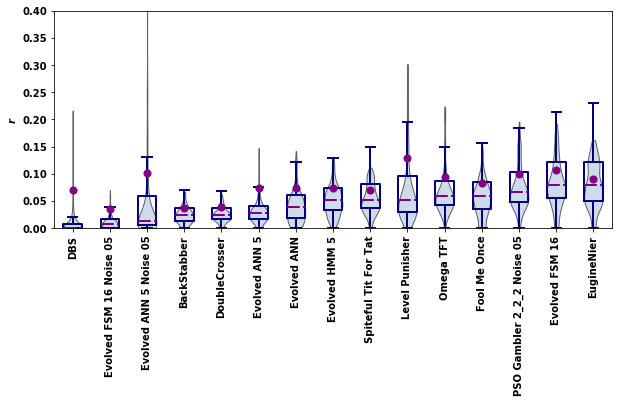

In [188]:
fig, axes = plt.subplots(figsize=(10, 4))

parts = axes.violinplot(violin_data, showextrema=False,
                        showmeans=False);

boxes = axes.boxplot(data, showfliers=False)
axes.scatter(range(1, len(means) + 1), means, marker='o', color='purple', zorder=3, s=50)

for pc in parts['bodies']:
    pc.set_facecolor('lightsteelblue')
    pc.set_edgecolor('black')
    pc.set_alpha(.60)

for bp in boxes['medians']:
    bp.set_color('purple')
    bp.set_linewidth(2)
    bp.set_linestyle('-.')
for bp in boxes['caps']:
    bp.set_color('navy')
    bp.set_linewidth(2)
for bp in boxes['whiskers']:
    bp.set_color('navy')
    bp.set_linewidth(2)
for bp in boxes['boxes']:
    bp.set_color('navy')
    bp.set_linewidth(2)

axes.set_ylabel(r'$r$')
axes.set_ylim([0, 0.4]);
axes.set_xticklabels(list(top_names), rotation=90);

plt.savefig('../images/noise_performance_subset.pdf', bbox_inches='tight')

Line plot with the ranks the strategies achieved?

**Mixed**

In [ ]:
from scipy.interpolate import griddata

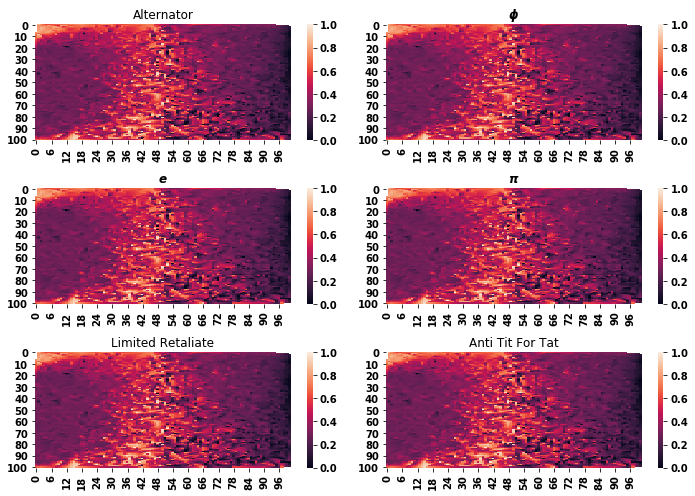

In [141]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 7))
for i, name in enumerate(top_names_mixed[:6]):
    mixed = dfs[3][dfs[3]['Name'] == name]
    mixed = mixed.round({'probend': 2, 'noise': 2})
    
    index = (int(i / 2), i % 2)
    
    data = mixed[['probend', 'noise', 'Normalized_Rank']]
    piv = pd.pivot_table(data, values="Normalized_Rank", 
                     index=["probend"],
                     columns=["noise"])
    
    z = piv.values
    X = piv.index
    Y = piv.columns
    
    array = np.ma.masked_invalid(z)
    xx, yy = np.meshgrid(X, Y)

    x1 = xx[~array.mask]
    y1 = yy[~array.mask]
    newarr = array[~array.mask]

    inter_data = interpolate.griddata((x1, y1), newarr.ravel(),
                                      (xx, yy),
                                       method='linear')
    
    sns.heatmap(GD1, ax=axes[index]);
    
    axes[index].set_title(name)
fig.tight_layout()

In [212]:
mixed = dfs[3][(dfs[3]['noise'] < 0.10) & (dfs[3]['probend'] < 0.10)]

In [216]:
mixed.groupby(['Name']).median()['Normalized_Rank'].round(decimals=3).sort_values()[:15]

Name
Raider                       0.022
MEM2                         0.037
Prober 3                     0.039
Evolved FSM 16 Noise 05      0.048
Hard Prober                  0.072
Spiteful Tit For Tat         0.078
Better and Better            0.089
Grudger                      0.091
Fortress4                    0.096
Meta Winner Memory One       0.099
NMWE Long Memory             0.099
Nice Meta Winner             0.104
NMWE Deterministic           0.109
NMWE Memory One              0.112
Nice Meta Winner Ensemble    0.115
Name: Normalized_Rank, dtype: float64

In [217]:
len(mixed['seed'].unique())

117

In [219]:
table = pd.DataFrame(mixed.groupby(['Name']).median()['Normalized_Rank'].round(decimals=3).sort_values()[:15])
table = table.rename(columns={'Normalized_Rank':
                              r'$\bar{r}$'})
table.to_latex('../paper/performance_probend_noise_subset_table.tex')